In [759]:
import pandas as pd

# Load JSON data into a DataFrame
df = pd.read_json('merged_sorted_intersections_ahmad.json')

FEATURE ENGINEERING AND EXRTACTION

In [760]:
# categorize trafficIDs from strings that contain letters and numbers to just numbers
df['trafficID'] = df['trafficID'].astype('category').cat.codes

In [761]:
# Convert timestamps to datetime if they aren't already
df['timeStamp'] = pd.to_datetime(df['timeStamp'])

# Extract date and time components
df['hour'] = df['timeStamp'].dt.hour
df['minute'] = df['timeStamp'].dt.minute
df['second'] = df['timeStamp'].dt.second


# Assumption: 70% of cars go forward, 20% turn left, 10% turn right.
# These assumptions will be replaced with actual data in the future using sensors.
df['forward_flow'] = round(df['num_cars'] * 0.7)
df['left_flow'] = round(df['num_cars'] * 0.2)
df['right_flow'] = round(df['num_cars'] * 0.1)

# Calculate flow ratios for each direction
df['forward_flow_ratio'] = df['forward_flow'] / df['num_cars']
df['left_flow_ratio'] = df['left_flow'] / df['num_cars']
df['right_flow_ratio'] = df['right_flow'] / df['num_cars']


In [762]:
# Temporal Features based on trafficID
df['time_since_last_green'] = df.groupby('trafficID')['timeStamp'].diff().dt.total_seconds().fillna(0)

# Average time between green signals
df['avg_time_between_greens'] = df.groupby('trafficID')['timeStamp'].diff().dt.total_seconds().groupby(df['trafficID']).transform('mean').fillna(0)

In [763]:
# Peak flow is the maximum flow of cars in any direction categorized into  0, 1, 2
# 0: forward flow, 1: left flow, 2: right flow
df['peak_flow'] = df[['forward_flow', 'left_flow', 'right_flow']].idxmax(axis=1).astype('category').cat.codes


In [764]:
def categorize_time_of_day(hour):
    '''Categorize the time of day based on the hour of the day.'''
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

df['part_of_day'] = df['hour'].apply(categorize_time_of_day)

In [765]:
# Calculate the difference in car count between consecutive time stamps by traffic ID
df['car_count_diff'] = df.groupby('trafficID')['num_cars'].diff()

In [766]:
# Calculate the exponential moving average of the number of cars
df['ema_cars'] = df['num_cars'].ewm(span=10, adjust=False).mean()

In [767]:
# Create a columns to indicate whether the day is a weekend or not
df['weekday'] = df['timeStamp'].dt.weekday
df['is_weekend'] = df['weekday'].apply(lambda x: 1 if x >= 5 else 0)

In [768]:
# Create a column to indicate whether the day is a public holiday or not
public_holidays = set(['2024-09-23', '2025-02-22']) # Saudi National Day and Founding Day of the Kingdom of Saudi Arabia
df['is_public_holiday'] = df['timeStamp'].dt.date.astype(str).isin(public_holidays).astype(int)

In [769]:
import numpy as np
# Create a column to indicate the time of day as a sin/cos pair
period = 7 * 24  # 7 days * 24 hours
df['sin_time'] = np.sin(2 * np.pi * df['timeStamp'].dt.hour / period)
df['cos_time'] = np.cos(2 * np.pi * df['timeStamp'].dt.hour / period)


In [770]:
# Removing NaN values from car_count_diff column and setting them to 0
df['car_count_diff'].fillna(value=0, inplace=True)
# df['weatherStamp:'].fillna(value=30, inplace=True)

C:\Users\omars\AppData\Local\Temp\ipykernel_18236\909880472.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['car_count_diff'].fillna(value=0, inplace=True)


In [771]:
# Group by date and trafficID, calculate the mean of the 3 flow directions, then calculate the mean of the 3 flow directions
daily_std_dev = df.groupby(['dateStamp', 'trafficID'])[['forward_flow', 'left_flow', 'right_flow']].std().mean(axis=1).reset_index()

# Rename the column for clarity
daily_std_dev.columns = ['dateStamp', 'trafficID', 'daily_std_dev']

# Merge the daily standard deviation back to the original DataFrame
df = pd.merge(df, daily_std_dev, on=['dateStamp', 'trafficID'])

In [772]:
# Data handling before model training
# convert timestamp to numeric
df['timeStamp_numeric'] = df['timeStamp'].apply(lambda x: x.timestamp())
# convert dateStamp from str to datetime then to numeric
df['dateStamp'] = pd.to_datetime(df['dateStamp'])
df['dateStamp_numeric'] = df['dateStamp'].apply(lambda x: x.timestamp())
# drop the original timestamp and datestamp columns
df.drop(['timeStamp', 'dateStamp'], axis=1, inplace=True)

In [773]:
# change part_of_day to categories and then to numeric
df['part_of_day'] = df['part_of_day'].astype('category').cat.codes  # convert to numeric

In [774]:
# Dropping unneeded columns
# Drop hour, min, second
df.drop(['hour', 'minute', 'second'], axis=1, inplace=True)

# drop flow ratios
df.drop(['forward_flow_ratio', 'left_flow_ratio', 'right_flow_ratio'], axis=1, inplace=True)

# drop timeStamp_numeric
df.drop(['timeStamp_numeric'], axis=1, inplace=True)

# drop weatherStamp:
df.drop(['weatherStamp:'], axis=1, inplace=True)



In [775]:
# Convert all str columns in df to numeric (float)
for col in df.columns:
    if df[col].dtype == 'str':
        df[col] = pd.to_numeric(df[col], errors='coerce', inplace=True)

In [776]:
df.columns


Index(['trafficID', 'num_cars', 'greenTime', 'forward_flow', 'left_flow',
       'right_flow', 'time_since_last_green', 'avg_time_between_greens',
       'peak_flow', 'part_of_day', 'car_count_diff', 'ema_cars', 'weekday',
       'is_weekend', 'is_public_holiday', 'sin_time', 'cos_time',
       'daily_std_dev', 'dateStamp_numeric'],
      dtype='object')

In [777]:
df.head()

,trafficID,num_cars,greenTime,forward_flow,left_flow,right_flow,time_since_last_green,avg_time_between_greens,peak_flow,part_of_day,car_count_diff,ema_cars,weekday,is_weekend,is_public_holiday,sin_time,cos_time,daily_std_dev,dateStamp_numeric
0,0,92,46,64.0,18.0,9.0,0.0,137.909091,0,0,0.0,92.000000,2,0,0,0.330279,0.943883,12.676529,1.722298e+09
1,4,0,3,0.0,0.0,0.0,0.0,31.006667,0,0,0.0,75.272727,2,0,0,0.330279,0.943883,0.000000,1.722298e+09
2,8,0,3,0.0,0.0,0.0,0.0,32.985816,0,0,0.0,61.586777,2,0,0,0.330279,0.943883,7.798172,1.722298e+09
3,12,72,36,50.0,14.0,7.0,0.0,148.322581,0,0,0.0,63.480090,2,0,0,0.330279,0.943883,10.611115,1.722298e+09
4,5,0,3,0.0,0.0,0.0,0.0,31.006667,0,0,0.0,51.938256,2,0,0,0.330279,0.943883,7.527539,1.722298e+09


In [778]:
for col in df.columns:
    print(f"{col}: {df[col].dtype}")

trafficID: int8
num_cars: int64
greenTime: int64
forward_flow: float64
left_flow: float64
right_flow: float64
time_since_last_green: float64
avg_time_between_greens: float64
peak_flow: int8
part_of_day: int8
car_count_diff: float64
ema_cars: float64
weekday: int32
is_weekend: int64
is_public_holiday: int32
sin_time: float64
cos_time: float64
daily_std_dev: float64
dateStamp_numeric: float64


In [779]:
# replace Nans with 0 and inf with 1e9
df.fillna(0, inplace=True)

Normalization

In [780]:
# Prepare the scaler
scaler = StandardScaler()

# Define columns to be scaled
columns_to_normalize = ['num_cars', 'daily_std_dev', 'time_since_last_green', 'avg_time_between_greens', 'ema_cars', 'car_count_diff', 'forward_flow', 'left_flow', 'right_flow']

# Normalize these columns
df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])


MODEL TESTING/BUILDING

Simple RandomForestRegressor

In [787]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Assuming you have already prepared X_train, X_test, y_train, y_test
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predictions
predictions = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print("Root Mean Squared Error:", rmse)


Root Mean Squared Error: 2.559771965914643


In [788]:
pip install xgboost



   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.5/124.9 MB 4.2 MB/s eta 0:00:30
    --------------------------------------- 2.6/124.9 MB 8.4 MB/s eta 0:00:15
   - -------------------------------------- 5.0/124.9 MB 9.7 MB/s eta 0:00:13
   -- ------------------------------------- 6.8/124.9 MB 9.5 MB/s eta 0:00:13
   -- ------------------------------------- 8.9/124.9 MB 9.5 MB/s eta 0:00:13
   --- ------------------------------------ 11.0/124.9 MB 9.7 MB/s eta 0:00:12
   ---- ----------------------------------- 12.6/124.9 MB 9.4 MB/s eta 0:00:12
   ---- ----------------------------------- 13.6/124.9 MB 9.0 MB/s eta 0:00:13
   ---- ----------------------------------- 14.9/124.9 MB 8.5 MB/s eta 0:00:13
   ----- ---------------------------------- 16.0/124.9 MB 8.3 MB/s eta 0:00:14
   ----- ---------------------------------- 17.3/124.9 MB 8.0 MB/s eta 0:00:14
   ----- ---------------------------------- 18.4/124.9 MB 7.8 MB

In [806]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np

# Define the model
model = xgb.XGBRegressor(objective ='reg:squarederror', 
                         colsample_bytree = 0.3, 
                         learning_rate = 0.1,
                         max_depth = 5, 
                         alpha = 10, 
                         n_estimators = 10000)

# Train the model
model.fit(X_train, y_train)

# Predictions
predictions = model.predict(X_test)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print("Root Mean Squared Error:", rmse)


Root Mean Squared Error: 1.9493093339663583


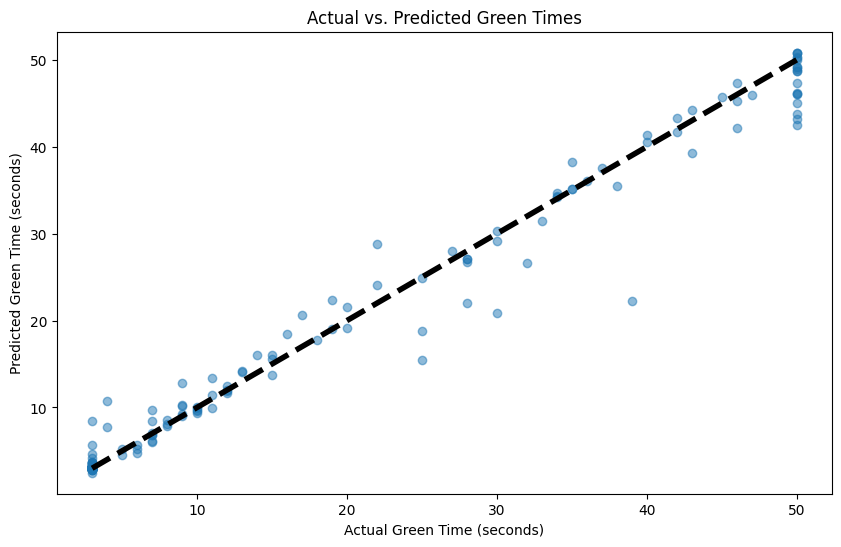

In [807]:
import matplotlib.pyplot as plt

# Assuming `predictions` are stored in `predictions` from your GBM model and `y_test` are the actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions, alpha=0.5)
plt.title('Actual vs. Predicted Green Times')
plt.xlabel('Actual Green Time (seconds)')
plt.ylabel('Predicted Green Time (seconds)')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.show()


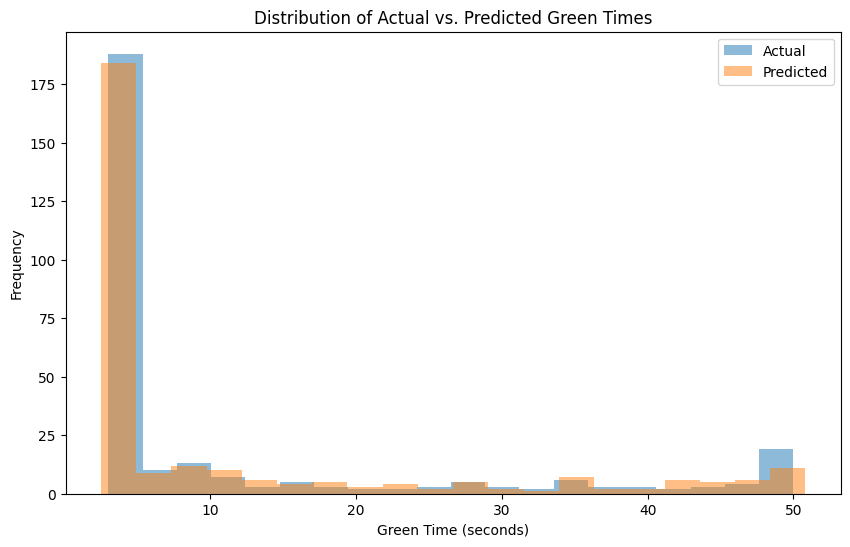

In [809]:
plt.figure(figsize=(10, 6))
plt.hist(y_test, bins=20, alpha=0.5, label='Actual')
plt.hist(predictions, bins=20, alpha=0.5, label='Predicted')
plt.title('Distribution of Actual vs. Predicted Green Times')
plt.xlabel('Green Time (seconds)')
plt.ylabel('Frequency')
plt.legend()
plt.show()


In [811]:
import plotly.express as px

fig = px.scatter(x=y_test, y=predictions, labels={'x': 'Actual Green Time', 'y': 'Predicted Green Time'},
                 title='Actual vs Predicted Green Times')
fig.add_shape(type='line', x0=y_test.min(), y0=y_test.min(), x1=y_test.max(), y1=y_test.max())
fig.show()


ModuleNotFoundError: No module named 'plotly'